# Communities

In [1]:
import networkx as nx
import numpy as np
G = nx.read_graphml("world_graph_attributes.graphml")


First, we will inspect the network

In [2]:
for node, data in G.nodes(data=True):
    print(node, data)

Afghanistan {'sentiment_score': 3.0, 'gdp': 19101353833}
China {'sentiment_score': 4.4, 'gdp': 19910000000000}
Egypt {'sentiment_score': 4.1, 'gdp': 303175127598}
France {'sentiment_score': 5.7, 'gdp': 2715518274227}
India {'sentiment_score': 6.0, 'gdp': 2611000000000}
Iran {'sentiment_score': 4.8, 'gdp': 445345282123}
Italy {'sentiment_score': 5.7, 'gdp': 2001244392042}
Pakistan {'sentiment_score': 4.7, 'gdp': 304400000000}
Qatar {'sentiment_score': 6.3, 'gdp': 183466208791}
Russia {'sentiment_score': 4.1, 'gdp': 1699876578871}
United_Kingdom {'sentiment_score': 6.1, 'gdp': 2827113184696}
United_States {'sentiment_score': 5.8, 'gdp': 21427700000000}
Uzbekistan {'sentiment_score': 4.1, 'gdp': 57921286440}
Albania {'sentiment_score': 5.9, 'gdp': 15278077447}
Bosnia_and_Herzegovina {'sentiment_score': 4.1, 'gdp': 20047848435}
Bulgaria {'sentiment_score': 5.2, 'gdp': 86000000000}
Germany {'sentiment_score': 5.5, 'gdp': 3845630030824}
Greece {'sentiment_score': 6.2, 'gdp': 209852761469}
Ir

In [3]:
print(len(G.nodes()))

192


In [4]:
G = G.to_undirected()

In [5]:
# Building the Louvain partition using NetworkX's built-in function (define a seed for reproducibility)
louvain_communities = nx.community.louvain_communities(G, seed = 10)
print(f"Total communities formed using Louvain method: {len(louvain_communities)}\n")


for i, community in enumerate(louvain_communities):
    print(f"Louvain Community {i+1} (n = {len(community)}): {list(community)[:5]}")
print("---")

Total communities formed using Louvain method: 6

Louvain Community 1 (n = 31): ['Bahrain', 'Syria', 'United_Arab_Emirates', 'Oman', 'Algeria']
Louvain Community 2 (n = 42): ['Sweden', 'Denmark', 'North_Macedonia', 'Slovakia', 'Azerbaijan']
Louvain Community 3 (n = 51): ['Kenya', 'Mozambique', 'Somalia', 'Burkina_Faso', 'Zimbabwe']
Louvain Community 4 (n = 32): ['Argentina', 'Guyana', 'Ecuador', 'Dominica', 'Mexico']
Louvain Community 5 (n = 35): ['Micronesia', 'Solomon_Islands', 'Philippines', 'Timor-Leste', 'Thailand']
Louvain Community 6 (n = 1): ['Saint_Vincent_and_the_Grenadines']
---


Now we will try to form communities based on language. Does not work now with the new network (does not have language). 

In [6]:
# Build communities by language
language_communities = {}

for node, data in G.nodes(data=True):
    language = data.get("official_language") 

    # skip nodes with missing values
    if language is None:
        print("Node with no language")
        print(node)
        continue

    language_communities[language] = node

Node with no language
Afghanistan
Node with no language
China
Node with no language
Egypt
Node with no language
France
Node with no language
India
Node with no language
Iran
Node with no language
Italy
Node with no language
Pakistan
Node with no language
Qatar
Node with no language
Russia
Node with no language
United_Kingdom
Node with no language
United_States
Node with no language
Uzbekistan
Node with no language
Albania
Node with no language
Bosnia_and_Herzegovina
Node with no language
Bulgaria
Node with no language
Germany
Node with no language
Greece
Node with no language
Ireland
Node with no language
Montenegro
Node with no language
Serbia
Node with no language
Spain
Node with no language
Algeria
Node with no language
Iceland
Node with no language
Libya
Node with no language
Mali
Node with no language
Malta
Node with no language
Mauritania
Node with no language
Morocco
Node with no language
Netherlands
Node with no language
Portugal
Node with no language
Tunisia
Node with no langu

In [ ]:
for lang, members in language_communities.items():
    print(f"Language: {lang} ({len(members)} nodes)")
    print(members[:10], "...\n")

Language: Nepali (5 nodes)
Nepal ...

Language: Standard Chinese (5 nodes)
China ...

Language: Hindi (5 nodes)
India ...

Language: Lao (4 nodes)
Laos ...

Language: Burmese (7 nodes)
Myanmar ...

Language: Turkish (6 nodes)
Turkey ...

Language: Armenian (7 nodes)
Armenia ...

Language: Georgian (7 nodes)
Georgia ...

Language: German (13 nodes)
Liechtenst ...

Language: Greek (6 nodes)
Cyprus ...

Language: Persian (10 nodes)
Tajikistan ...

Language: nan (5 nodes)
Japan ...

Language: Arabic (10 nodes)
Mauritania ...

Language: Spanish (18 nodes)
Dominican_ ...

Language: French (7 nodes)
Vanuatu ...

Language: Italian (10 nodes)
San_Marino ...

Language: nan (9 nodes)
Australia ...

Language: Pashto (11 nodes)
Afghanista ...

Language: English (21 nodes)
Saint_Kitt ...

Language: Malay (6 nodes)
Brunei ...

Language: nan (13 nodes)
United_Sta ...

Language: Vietnamese (7 nodes)
Vietnam ...

Language: Portuguese (13 nodes)
Guinea-Bis ...

Language: Indonesian (9 nodes)
Indonesia ..

I will now create the divisions of GDP and the sentiment score. We will consider 3 levels: 1, 2 and 3. A function will be developed that does that to use for the various attributes more easily. 

In [53]:
def classify_nodes_by_attribute(G, attribute, k=3):
    """
    Returns a dictionary mapping class_label -> list_of_nodes.
    The attribute has a higher value in the the higher levels.
    """

    # Collect values only from nodes that have the attribute (can be erased once the network is perfect)
    #values = []
    #nodes_with_attr = []
#
    #for n, data in G.nodes(data=True):
    #    if attribute not in data:
    #        print(f"Node '{n}' is missing attribute '{attribute}' — skipping.")
    #        continue
#
    #    # Extract attribute values
    #    values.append(data[attribute])
    #    nodes_with_attr.append(n)

    # Store the values
    #vals = np.array(values)
    vals = np.array([G.nodes[n][attribute] for n in G.nodes])

    #Use log to colapse the scale 
    vals = np.log(vals + 1) 

    # Compute partition boundaries
    bins = np.linspace(vals.min(), vals.max(), k + 1)

    # Create labels: Level_1, Level_2, ..., Level_k
    labels = [f"Level_{i+1}" for i in range(k)]

    # Prepare output dictionary
    classes = {label: [] for label in labels}

    # Assign nodes to classes
    for node, data in G.nodes(data=True):
        value = data.get(attribute)

        # Skip if missing
        if value is None:
            print(f"Node {node} has no attribute '{attribute}'")
            continue

        # Determine the partition index
        idx = np.digitize(value, bins) - 1 
        # clamp to valid range 
        idx = min(max(idx, 0), k-1)        

        classes[labels[idx]].append(node)

    return classes


In [60]:
def classify_nodes_by_attribute(G, attribute, k=3):
    """
    Classify countries into k levels based on the log of the attribute.
    """
    # extract attribute values
    vals = []
    for n in G.nodes:
        if attribute in G.nodes[n]:
            vals.append(G.nodes[n][attribute])

    vals = np.array(vals)

    # log-transform
    log_vals = np.log(vals + 1)

    # compute bins on log scale
    bins = np.linspace(log_vals.min(), log_vals.max(), k + 1)

    labels = [f"Level_{i+1}" for i in range(k)]
    classes = {label: [] for label in labels}

    # Assign nodes to classes
    for node, data in G.nodes(data=True):
        value = data.get(attribute)

        if value is None:
            print(f"Node {node} has no attribute '{attribute}'")
            continue

        # log-transform the node value too
        log_value = np.log(value + 1)

        idx = np.digitize(log_value, bins) - 1
        idx = min(max(idx, 0), k - 1)

        classes[labels[idx]].append(node)

    return classes


In [11]:
sentiment_partitions = classify_nodes_by_attribute(G, "sentiment_score", k=3)

In [12]:
sentiment_partitions["Level_1"]

['Afghanistan',
 'Libya',
 'Mali',
 'Democratic_Republic_of_the_Congo',
 'Niger',
 'Zimbabwe',
 'Guinea',
 'Lebanon',
 'Belarus',
 'Mozambique',
 'Burkina_Faso',
 'Burundi',
 'Chad',
 'Central_African_Republic',
 'Nicaragua',
 'Haiti',
 'South_Sudan',
 'Yemen',
 'Equatorial_Guinea',
 'Liberia',
 'Guinea-Bissau',
 'Turkmenistan',
 'Tajikistan',
 'Myanmar',
 'Suriname']

In [13]:
print(len(sentiment_partitions["Level_2"]))

116


In [14]:
print(sentiment_partitions["Level_3"])

['France', 'India', 'Italy', 'Qatar', 'United_Kingdom', 'United_States', 'Albania', 'Greece', 'Spain', 'Iceland', 'Malta', 'Netherlands', 'Portugal', 'Andorra', 'Australia', 'Belgium', 'Canada', 'Chile', 'Denmark', 'Japan', 'New_Zealand', 'Switzerland', 'Singapore', 'Austria', 'Liechtenstein', 'Luxembourg', 'Slovenia', 'Norway', 'Belize', 'Bhutan', 'Sweden', 'Botswana', 'Brunei', 'Senegal', 'Tanzania', 'Ecuador', 'Costa_Rica', 'Czech_Republic', 'Finland', 'Tonga', 'Jordan', 'Nauru', 'Tuvalu', 'United_Arab_Emirates', 'Maldives', 'Palau', 'Seychelles', 'Monaco', 'South_Korea', 'San_Marino', 'The_Bahamas']


In [166]:
gdp_partitions = classify_nodes_by_attribute(G,'gdp', k=3)

In [170]:
print(len(gdp_partitions["Level_3"]))

43


In [69]:
print(len(gdp_partitions["Level_4"]))

47


In [70]:
print(len(gdp_partitions["Level_5"]))

12


In [73]:
print(len(gdp_partitions["Level_2"]))

41


In [71]:
print(len(gdp_partitions["Level_1"]))

9


In [72]:
print(gdp_partitions["Level_1"])

['Dominica', 'Tonga', 'Kiribati', 'Nauru', 'Tuvalu', 'Marshall_Islands', 'Micronesia', 'Palau', 'São_Tomé_and_Príncipe']


In [41]:
print(gdp_partitions["Level_5"])

[]


In [42]:
print(len(gdp_partitions["Level_4"]))

0


Results of TF-IDF are not making much sense right now. I believe considering GDP per capita will result in a better behaviour. 

# TF-IDF 

In [18]:
import os
import math
import random
import string
import pickle as pkl
from io import StringIO
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import networkx as nx
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
import powerlaw
from google import genai

In [ ]:
# initialize the list of common English stopwords and a lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_tokenize_optimized(text, rare_threshold=None):
    """
    Improved tokenizer for historical/narrative TF-IDF analysis.
    - lowercase
    - remove punctuation/numbers
    - lemmatize
    - remove stopwords AFTER lemmatization
    - optional rare filtering at global level (NOT per document)
    """

    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # tokenize
    tokens = text.split()

    # lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # remove stopwords (after lemmatization)
    tokens = [t for t in tokens if t not in stop_words]

    # remove very short tokens
    tokens = [t for t in tokens if len(t) > 2]

    # Does not remove rare words because they might be important in historical context
    if rare_threshold:
        freq = Counter(tokens)
        tokens = [t for t in tokens if freq[t] >= rare_threshold]

    return tokens

In [ ]:
def clean_tokenize_bigram(text):
    """
    Tokenizer that returns only bigrams.
    - Lowercase
    - Remove punctuation and numbers
    - Lemmatize unigrams
    - Remove stopwords
    - Build bigrams after cleaning
    """

    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # split into unigrams
    tokens = text.split()

    # lemmatize unigrams
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # remove stopwords (after lemmatization)
    tokens = [t for t in tokens if t not in stop_words]

    # remove very short tokens
    tokens = [t for t in tokens if len(t) > 2]

    # build bigrams
    bigrams = [tokens[i] + "_" + tokens[i+1] for i in range(len(tokens)-1)]

    return bigrams


In [ ]:
# initialize the list of common English stopwords and a lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_tokenize_unigram(text, rare_threshold=5):
    """
    Clean, tokenize, and lemmatize a text string.
    - Lowercase
    - Remove punctuation and numbers
    - Remove stopwords
    - Lemmatize words
    - Filter out rare words (freq < rare_threshold)

    Parameters:
    text: str
        Text being clean 
    rare_threshold: int
        Minimum number of times a word needs to appear in a text to be considered

    Returns
    tokens : list of str
        List of cleaned, lemmatized tokens that occur at least
        'rare_threshold' times in the text.
    """
    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)

    # tokenize (split on whitespace)
    tokens = text.split()

    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # lemmatize (reduce words to their base form)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # filter rare words
    freq = Counter(tokens)
    tokens = [t for t in tokens if freq[t] >= rare_threshold]

    return tokens

def clean_tokenize(text, rare_threshold=5):
    """
    Clean, tokenize, lemmatize and ALSO produce bigrams.
    """

    # lowercase
    text = text.lower()

    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)

    # tokenize (split on whitespace)
    tokens = text.split()

    # remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # build bigrams (AFTER lemmatization)
    bigrams = [tokens[i] + "_" + tokens[i+1] for i in range(len(tokens)-1)]

    # combine unigrams + bigrams
    all_tokens = tokens + bigrams

    # filter rare words based on frequencies in this text
    freq = Counter(all_tokens)
    all_tokens = [t for t in all_tokens if freq[t] >= rare_threshold]

    return all_tokens



def compute_tf_for_communities(base_path, communities, out_folder, prefix="community"):
    """
    Compute term-frequency lists (TF) for a set of communities.

    Parameters  
    base_path : Path
        Folder with artist text files (.txt)
    communities : dict or list
        - If dict: {community_name: [artists]}
        - If list: [set(artists), set(artists), ...]
    out_folder : Path
        Output folder to store TF files
    prefix : str
        Prefix for naming files (e.g. 'primary', 'random', 'louvain')

    Returns
    genre_texts : dict
        Dictionary mapping each community name to a 'Counter' object containing
        the term frequencies of that community.
    """
    out_folder.mkdir(exist_ok=True)
    genre_texts = defaultdict(list)

    # normalize to dict form for convenience
    if isinstance(communities, list):
        communities = {f"{prefix}_{i+1}": list(c) for i, c in enumerate(communities)}

    # tokenize 
    for name, countries in communities.items():
        combined_tokens = []
        for artist in countries:
            file_path = base_path / f"{artist.replace(' ', '_').lower()}.txt"
            text = file_path.read_text(encoding="utf-8")
            tokens = clean_tokenize(text)
            combined_tokens.extend(tokens)

        # compute and save TF for this community
        counts = Counter(combined_tokens)
        genre_texts[name] = counts

        # store TF lists
        if prefix== "louvain":
            out_file = out_folder / f"{name}_TF.txt"
        else:
            out_file = out_folder / f"{prefix}_{name}_TF.txt"
            
        with open(out_file, "w", encoding="utf-8") as f:
            for word, count in counts.most_common():
                f.write(f"{word} {count}\n")

    return genre_texts

In [145]:
def compute_tfidf(group_folder, label_type, top_n=10):
    """
    Compute TF-IDF for each group/community from the files containing the TF lists.

    Parameters
    group_folder : str or Path
        Path to the folder containing the TF lists files for each group or community.
    label_type : str
        Label indicating the type of grouping ("primary", "random", or "louvain"),
        used for formatting the printed output.
    top_n : int, optional
        Number of top words to display for each group based on TF-IDF score.
        Default is 10.

    Returns
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of {word: TF-IDF value}.
        
    """
    group_folder = Path(group_folder)
    group_tf = {}
    all_words = set()

    # load TF lists 
    for file in group_folder.glob("*_TF.txt"):
        name = file.stem  

        #  remove prefix
        for prefix in ["sentiment_score", "gdp_", "louvain_"]:
            if name.lower().startswith(prefix):
                prefix_removed = name[len(prefix):]
                detected_prefix = prefix  
                break

        # remove "_TF"
        prefix_removed = prefix_removed[:-3]

        # clean up spacing and capitalization
        clean_name = prefix_removed.strip().upper()

        # store words and frequencies
        counts = Counter()
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                    word, freq = line.strip().split()
                    freq = int(freq)
                    counts[word] = freq
                    all_words.add(word)
        group_tf[clean_name] = counts

    # compute DF 
    df = Counter()
    for word in all_words:
        df[word] = sum(1 for tf_counts in group_tf.values() if word in tf_counts)

    # compute IDF 
    N = len(group_tf)
    idf = {word: math.log((N + 1) / (df[word] + 1)) for word in all_words}

    # compute TF-IDF 
    group_tfidf = {}
    for group_name, tf_counts in group_tf.items():
        total_words = sum(tf_counts.values())
        tfidf = {word: (count / total_words) * idf[word] for word, count in tf_counts.items()}
        group_tfidf[group_name] = tfidf

    # print the results
    for group_name, tfidf_dict in group_tfidf.items():
        if "louvain" in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for Louvain community {group_name.replace('_', ' ')} ===")
        elif 'gdp' in label_type.lower():
            print(f"\n=== Top {top_n} TF-IDF words for the {detected_prefix.replace('_', ' ').upper()}attribute: {group_name.replace('_', ' ').title()} ===")
        else: 
            print(f"\n=== Top {top_n} TF-IDF words for the {detected_prefix.replace('_', ' ')} attribute: {group_name.replace('_', ' ').title()} ===")
        top_items = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            print(f"{word:<20s} {score:>10.6f}")

    return group_tfidf


In [169]:
# Path to the folder containing the text from each Wikipedia page 
base_path = Path("countries_pages")

In [167]:
# TF lists considering the sentiment score 
tf_sentiment = compute_tf_for_communities(base_path, sentiment_partitions, Path("Sentiment_TF"), prefix="sentiment_score")

# TF lists considering the GDP level
tf_gdp = compute_tf_for_communities(base_path, gdp_partitions, Path("GDP_TF"), prefix="gdp")

# TF lists for the Louvain communities
tf_louvain = compute_tf_for_communities(base_path, louvain_communities, Path("Louvain_TF"), prefix="louvain")

In [168]:
# TF-IDF considering levels of GDP
tfidf_gdp = compute_tfidf("GDP_TF", label_type="GDP Level")


=== Top 10 TF-IDF words for the GDP attribute: Level 1 ===
solomon                0.004226
samoa                  0.003868
andorra                0.003724
marshall               0.003151
burundi                0.003080
bhutan                 0.002722
nauru                  0.002507
atoll                  0.002507
funafuti               0.002435
palau                  0.002363

=== Top 10 TF-IDF words for the GDP attribute: Level 2 ===
soviet                 0.001752
sudan                  0.001458
bosnia                 0.001427
guatemala              0.001294
serbia                 0.001253
armenia                0.001160
brunei                 0.001160
luxembourg             0.001088
kuwait                 0.001078
greece                 0.001037

=== Top 10 TF-IDF words for the GDP attribute: Level 3 ===
ireland                0.002895
norway                 0.002316
singapore              0.001712
irish                  0.001410
sweden                 0.001369
argentine           

In [163]:
# TF-IDF considering sentiment scores
tfidf_sentiment = compute_tfidf("Sentiment_TF", label_type="Sentiment Score")


=== Top 10 TF-IDF words for the sentiment score attribute:  Level 1 ===
afghanistan            0.003985
yemen                  0.003892
libya                  0.002626
mali                   0.002391
burkina                0.002251
lebanese               0.002204
belarusian             0.002204
myanmar                0.002204
lebanon                0.002082
aden                   0.002063

=== Top 10 TF-IDF words for the sentiment score attribute:  Level 2 ===
bosnia                 0.001472
armenian               0.001302
serbia                 0.001292
armenia                0.001196
kuwait                 0.001112
sri                    0.001048
iran                   0.001027
hungarian              0.001006
sierra                 0.000974
fiji                   0.000963

=== Top 10 TF-IDF words for the sentiment score attribute:  Level 3 ===
sweden                 0.003853
brunei                 0.003202
luxembourg             0.003003
norway                 0.002607
denmark      

In [164]:
# TF-IDF considering louvain communities
tfidf_louvain = compute_tfidf("Louvain_TF", label_type="Louvain")


=== Top 10 TF-IDF words for Louvain community 1 ===
arab                   0.009680
israel                 0.009186
lebanon                0.008986
al                     0.007655
syria                  0.007588
bin                    0.007256
kuwait                 0.006989
syrian                 0.006723
pakistan               0.006457
bahrain                0.006257

=== Top 10 TF-IDF words for Louvain community 2 ===
bosnia                 0.006500
sweden                 0.006359
hungary                0.006126
poland                 0.005939
armenian               0.005752
serbia                 0.005705
germany                0.005331
armenia                0.005284
russian                0.005118
luxembourg             0.004957

=== Top 10 TF-IDF words for Louvain community 3 ===
sudan                  0.007508
congo                  0.006979
sierra                 0.004864
ethiopia               0.004335
leone                  0.004335
somali                 0.004124
sierra_le

We will now try to look for bigrams as well in our TF-IDF analysis. I think it could be good to include the analysis together and then separate, especially of the bigrams, bacause it can show some nice results. 

### Visualization

In [122]:
def plot_tfidf_bars(group_tfidf, label_type, top_n=10, save_path=None):
    """
    Create bar plots showing the top TF-IDF words for selected groups or communities.

    Parameters
    group_tfidf : dict
        Dictionary mapping each group name to a dictionary of words and
        their corresponding TF-IDF values.
        
    label_type : str
        Type of community/genre attribution used in the analysis.
        Used in the figure title.
    top_n : int, optional
        Number of top words to display for each group. Default is 10.
    save_path : str or Path, optional
        File path to save the resulting figure. If not provided, the plot is shown
        interactively instead.
    top_genres : list of str, optional
        List of genre or community names to include in the plots.
        If None, all groups in 'group_tfidf' are plotted.

    Returns
    None
    """

    # Format Community Names
    def format_group_name(name):
        name = name.replace("_", " ")       
        name = name.title()                  
        return name
    
    # Prepare plotting data 
    rows = []
    for group, scores in group_tfidf.items():
        top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for word, score in top_items:
            rows.append((format_group_name(group), word, score))
    df = pd.DataFrame(rows, columns=["Group", "Word", "TF-IDF"])

    # Determine grid layout
    n_groups = df["Group"].nunique()
    n_cols = min(4, n_groups)
    n_rows = math.ceil(n_groups / n_cols)

    # Create subplots grid 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows), sharey=False)
    axes = axes.flatten() if n_groups > 1 else [axes]

    # Plot each group 
    palette = sns.color_palette("Set2", n_groups)
    for ax, (group, subdf), color in zip(axes, df.groupby("Group"), palette):
        sns.barplot(
            data=subdf,
            y="Word",
            x="TF-IDF",
            ax=ax,
            color=color
        )
        ax.set_title(group, fontsize=13, weight="bold")
        ax.set_xlabel("TF-IDF score", fontsize=11)
        ax.set_ylabel("")
        ax.invert_yaxis()
        sns.despine(ax=ax)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.xaxis.get_offset_text().set_fontsize(10)

    # Hide unused axes 
    for j in range(len(df["Group"].unique()), len(axes)):
        axes[j].set_visible(False)

    # Figure title and layout 
    fig.suptitle(f"Top {top_n} TF-IDF Words considering {label_type}",
                 fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save or show 
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.show()

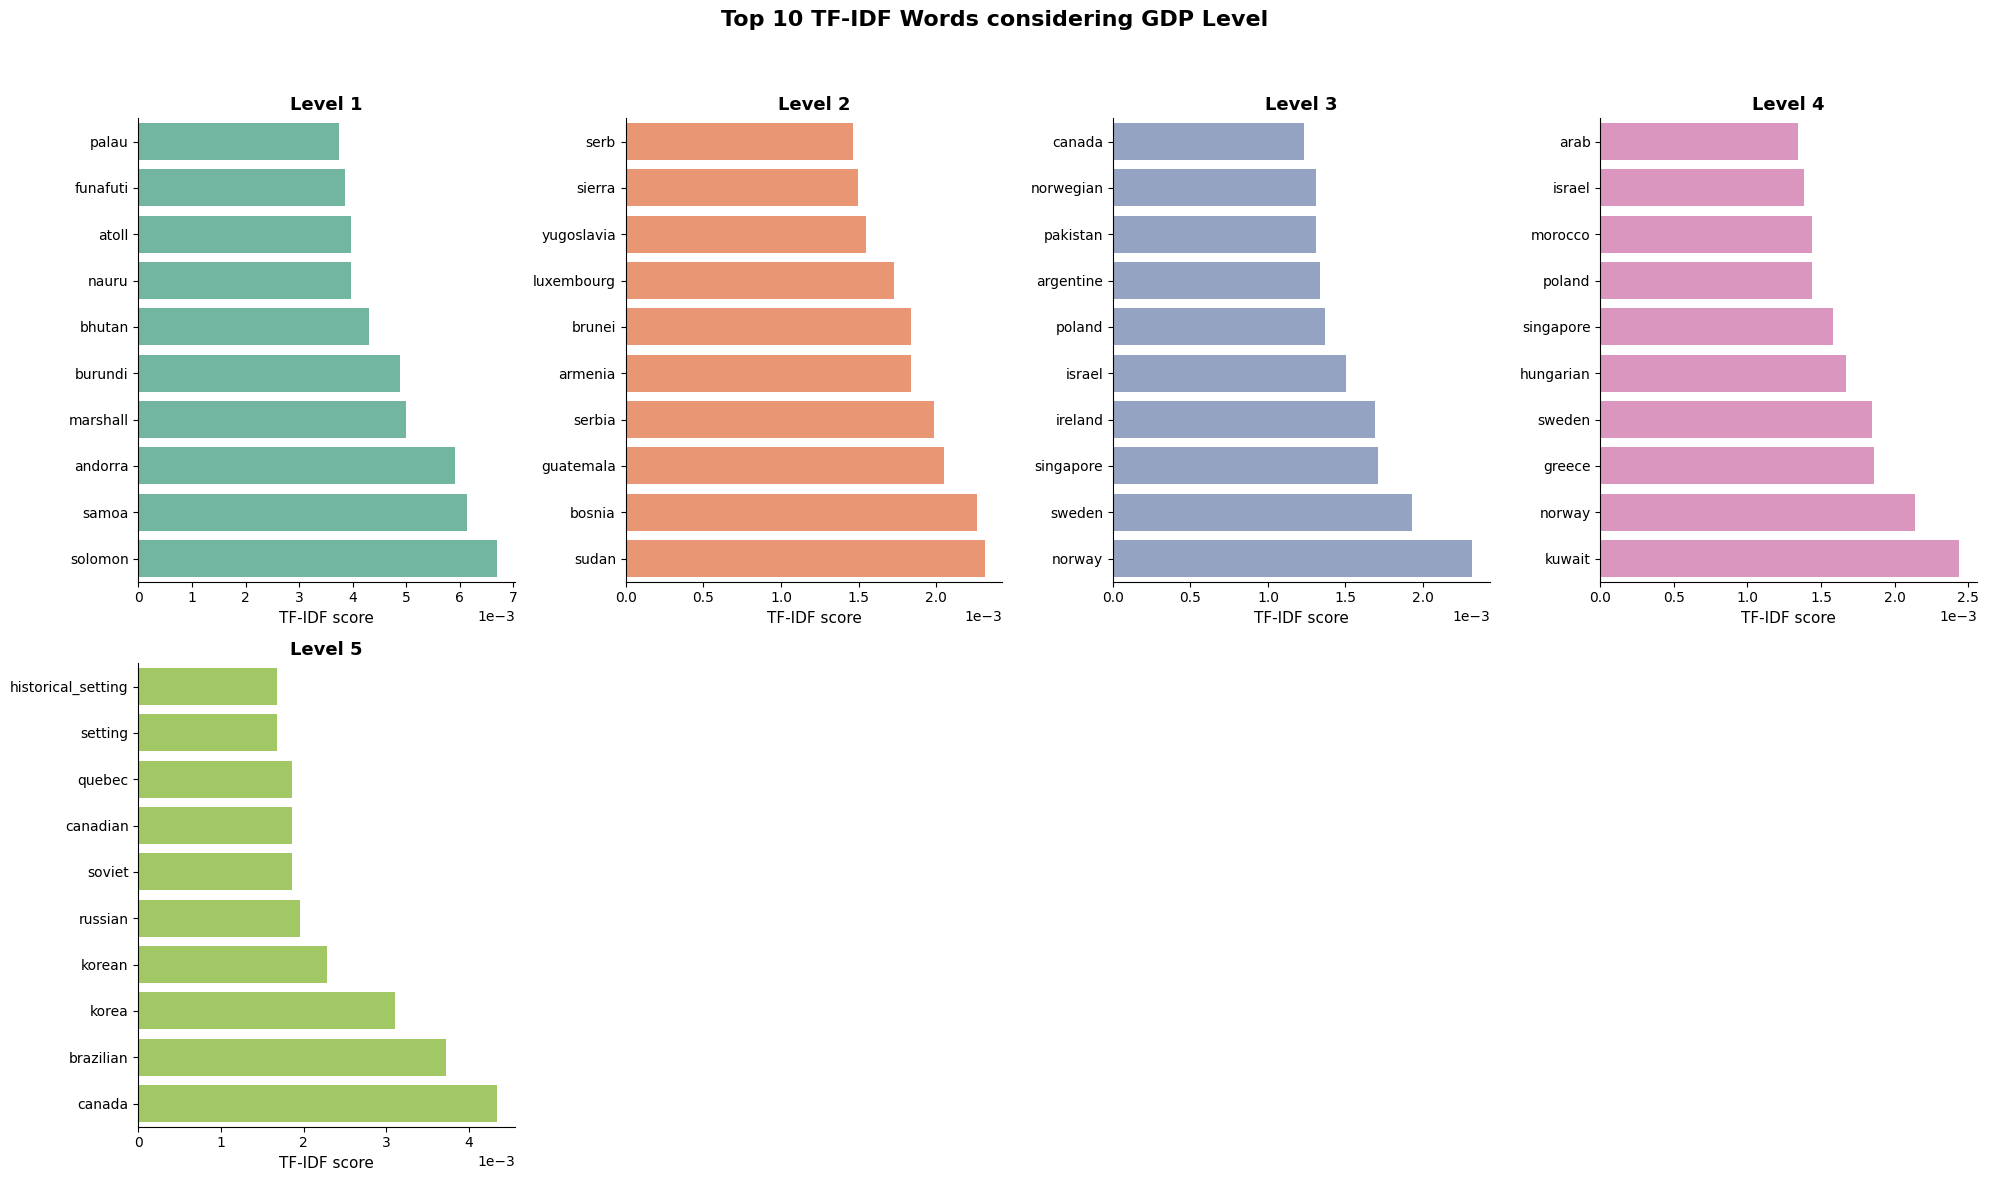

In [165]:
plot_tfidf_bars(tfidf_gdp, label_type="GDP Level", save_path="plots/tfidf_gdp.png")

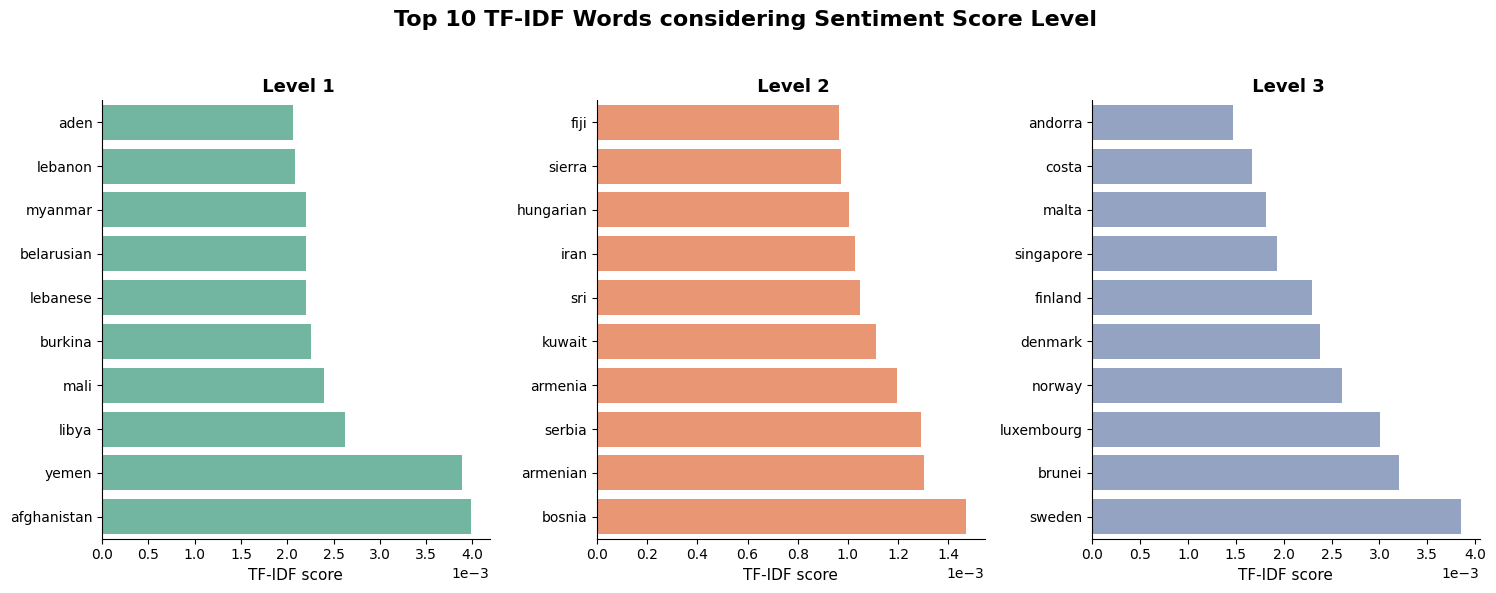

In [158]:
plot_tfidf_bars(tfidf_sentiment, label_type="Sentiment Score Level", save_path="plots/tfidf_sentiment.png")

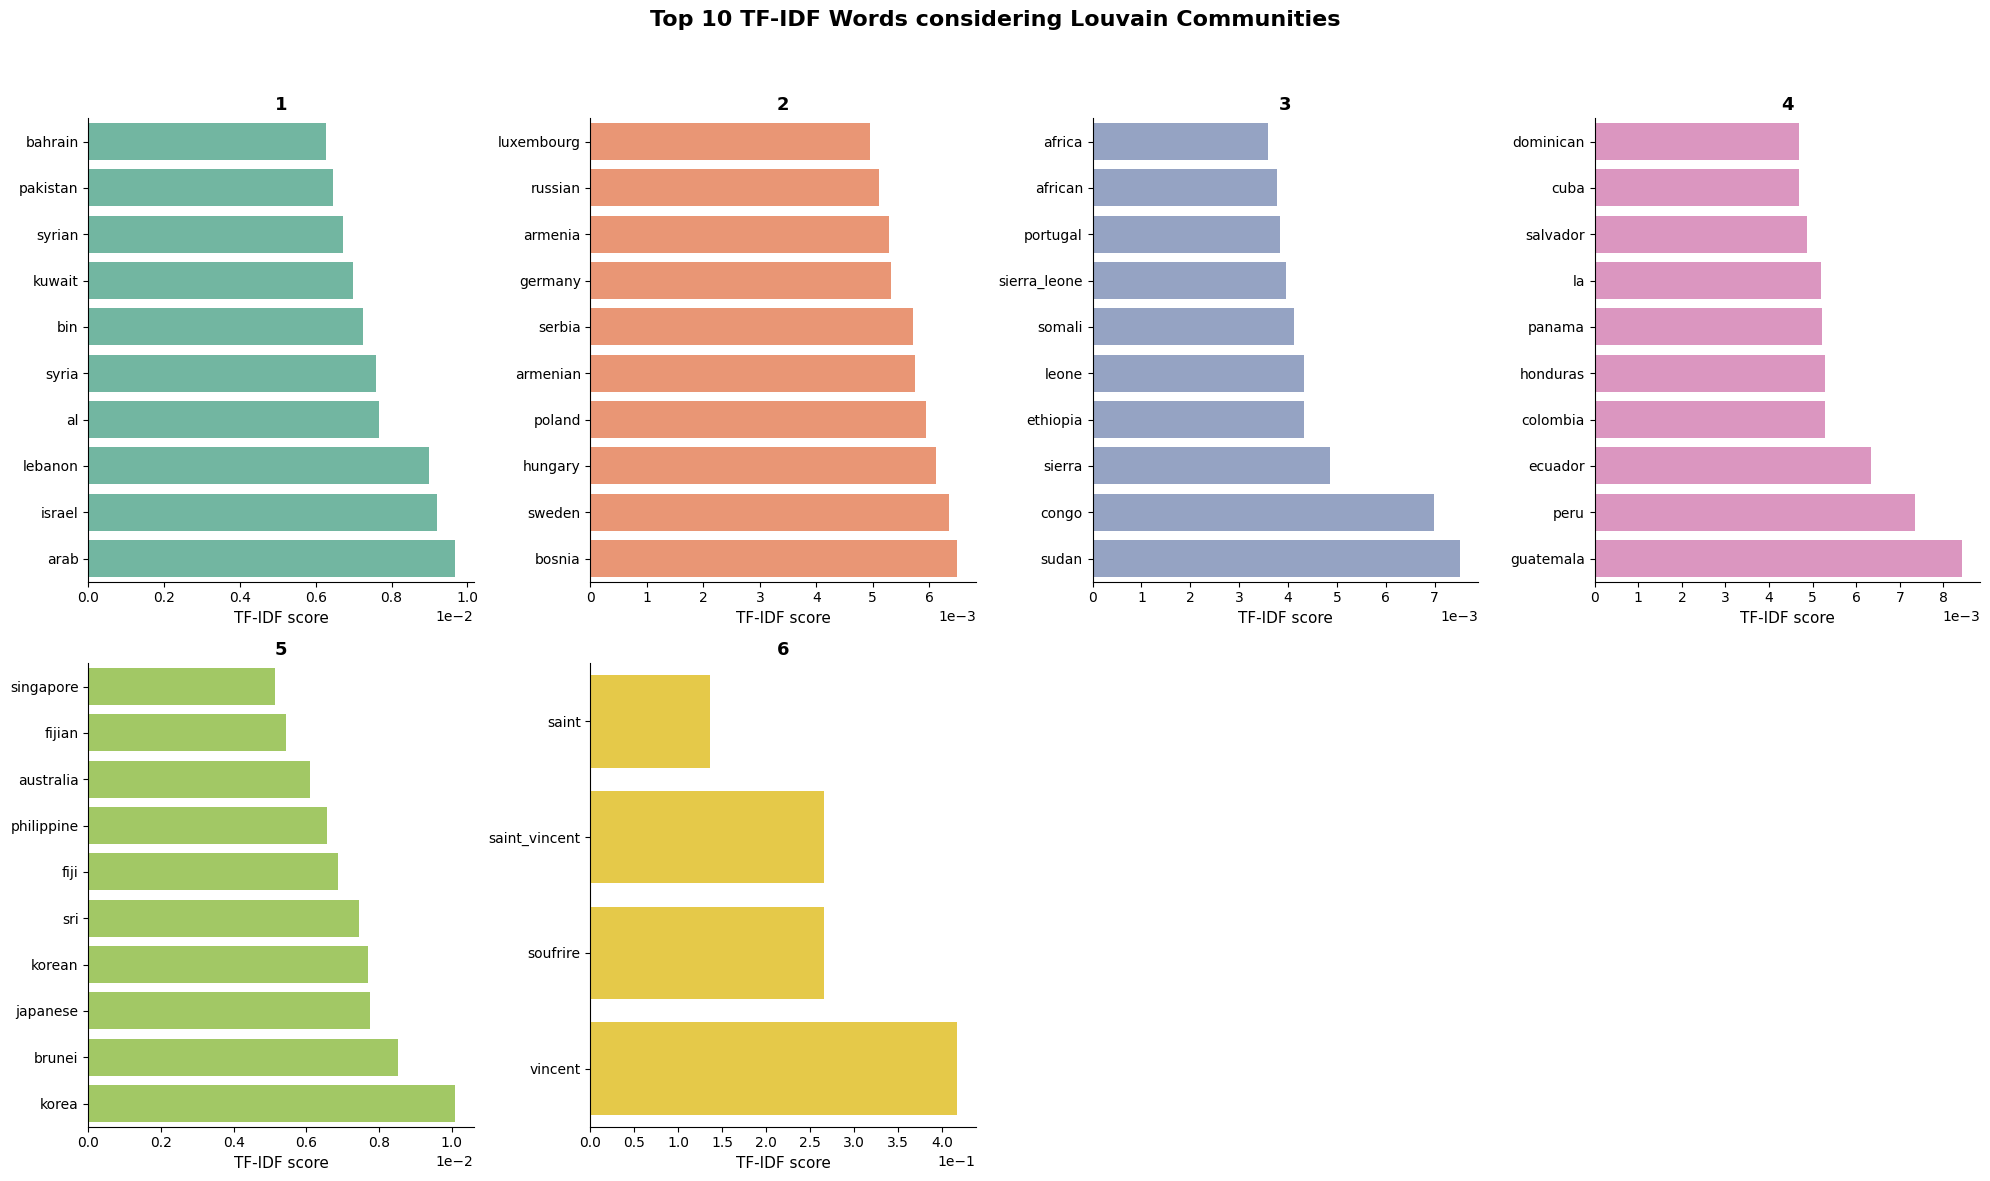

In [159]:
plot_tfidf_bars(tfidf_louvain, label_type="Louvain Communities", save_path="plots/tfidf_louvain.png")


### Word-Clouds

In [81]:
def create_wordclouds(group_tfidf, out_folder, max_words=100):
    """
    Create and save word clouds for each community/group based on TF-IDF scores.

    Parameters
    group_tfidf : dict
        Dict from compute_tfidf(): {group_name: {word: tfidf_value}}
    out_folder : str or Path
        Folder where the PNG files will be saved
    max_words : int
        Maximum number of words in each word cloud

    Returns
    None
    """
    out_folder = Path(out_folder)
    out_folder.mkdir(exist_ok=True)

    for group_name, tfidf_scores in group_tfidf.items():
        if not tfidf_scores:
            continue

        # Normalize values (to help visual scaling)
        max_val = max(tfidf_scores.values())
        freqs = {word: score / max_val for word, score in tfidf_scores.items()}

        # Create world-cloud 
        wc = WordCloud(
            width=1200,
            height=800,
            background_color="white",
            max_words=max_words,
            colormap="viridis",
            random_state=42
        ).generate_from_frequencies(freqs)

        # Save figure
        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        out_path = out_folder / f"{group_name}_wordcloud.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.close()

In [82]:
create_wordclouds(tfidf_gdp, "wordclouds_gdp_level")

In [83]:
create_wordclouds(tfidf_sentiment, "wordclouds_sentiment_score_level")

In [84]:
create_wordclouds(tfidf_louvain, "wordclouds_louvain")

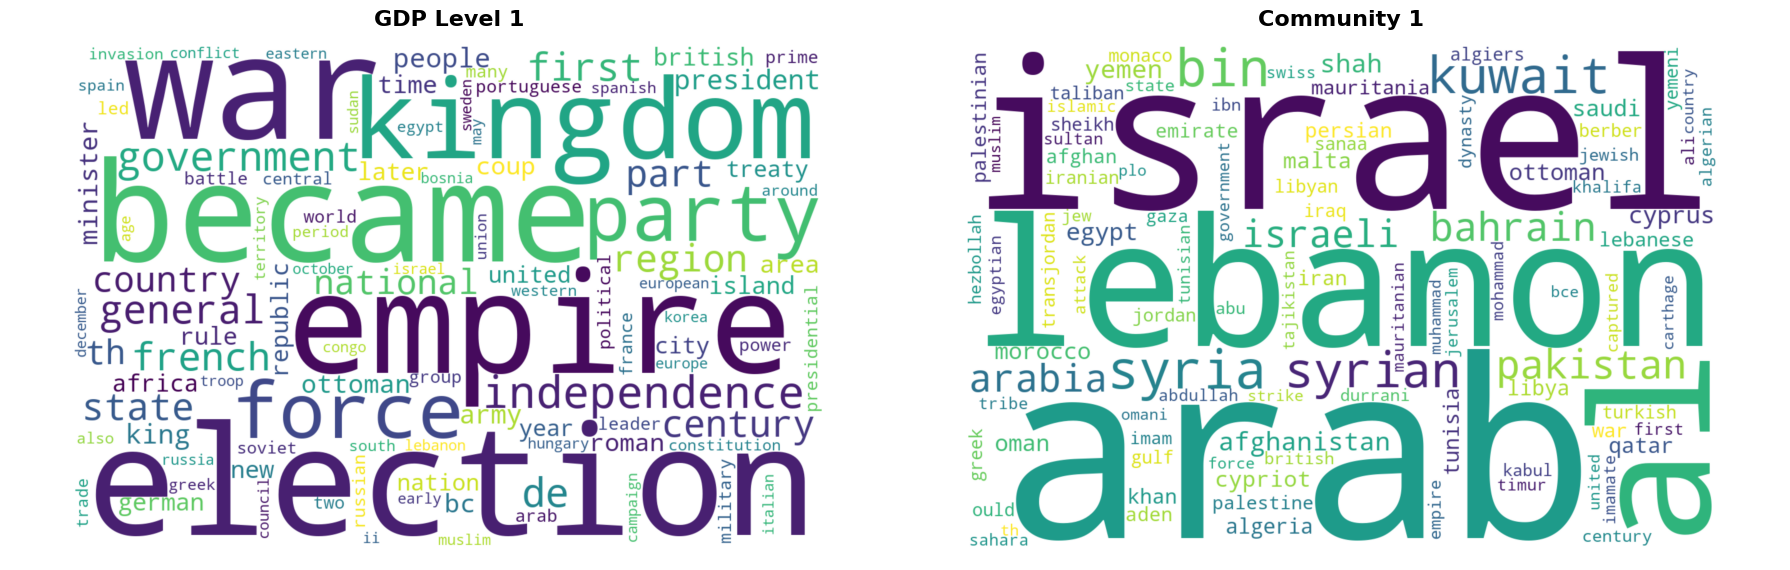

In [125]:
# image paths 
img1 = Path("wordclouds_gdp_level\LEVEL_1_wordcloud.png")     
img2 = Path("wordclouds_louvain/1_wordcloud.png")      

titles = [ "GDP Level 1", "Community 1"]

# Plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax, img_path, title in zip(axes, [img1, img2], titles):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title, fontsize=16, weight="bold")

plt.tight_layout()
plt.show()